# FIN 514 - Project 1 - Product 1 - Ford
**Spring 2022**

https://www.sec.gov/Archives/edgar/data/0000927971/000121465922002254/g210227424b2.htm

This notebook provides a model valuation for Product 1 (Ford).
We will assume a continuous dividend yield here for ease of calculation
Default volatility will be at the money but we will consider volatilities corresponding to different dates corresponding to autocall dates and moneyness levels corresponding to the contingent income barrier.

## Packages and Configurations

The following common packages will be use on this notebook.

* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# ENTER INPUTS FOR STOCK

N = 730
T1 = 730/365
T2 = 735/365
S0 = 18.35
B = 0.55*S0
#r1 goes to valuation for stock price movements
r1 = 0.013257332
#r2 goes to maturity for discounting
r2 = 0.013292329
q = 0.0225
#Put in all vols from 75% moneyness to ATM for sensitivity
vol = np.zeros([7])
vol[1] = 0.5088
vol[2] = 0.4945
vol[3] = 0.4819
vol[4] = 0.4764
vol[5] = 0.4749
vol[6] = 0.4685

In [3]:
# Enter key dates for product
Face = 1000 
NC = 4
Coupon_rate = 0.13
Cpn = Face*Coupon_rate/NC
#Coupon only dates
tco = [89/365]
tcop = [92/365]
tac = [181/365, 273/365, 365/365, 454/365, 546/365, 638/365]
tacp = [184/365, 279/365, 370/365, 457/365, 551/365, 643/365]


## Binomial Model Function

In [4]:

def CRRPR1_model(S0, B, T1, T2, r1, r2, q, sigma, N, n1max, Cpn, Face, tco, tcop, tac, tacp):
      
    # LIST TO SAVE RESULTS
    crrpr1_F_result = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    option_value = np.zeros([n1max*N+1, n1max*N+1])

    # CREATE ARRAY FOR STOCK PRICES OF SIZE N+1,N+1
    # stock_value[N+1, N+1]
    stock_value = np.zeros([n1max*N+1, n1max*N+1])    
    
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    for n1 in range(1, n1max+1):
        
        n = n1*N 
        
        delta = T1 / n
        u = np.exp(sigma * (delta)**0.5)
        d = 1 / u
        qu = (np.exp((r1-q) * delta) - d) / (u - d)
        qd = 1 - qu
        
        jco1 = [j/delta for j in tco]
        jco = [int(j) for j in jco1]
    
        jac1 = [j/delta for j in tac]
        jac = [int(j) for j in jac1]
        
    # CALCULATE OPTION VALUES AT CERTAIN STEPS AND POSITIONS WITHIN THE BINOMIAL TREE:
    # Start at the last step number because we are going to be moving backwards from step number n to step number 0
    # Hint: j = n and range stop = j 
        j = n 
        
        for i in range(0, j+1):    
  
            stock_value[j, i] = S0 * (u**i) * (d**(j - i))
            option_value[j, i] = (Face+Cpn)*np.exp(-r2*(T2-T1))
            if stock_value[j, i] < B:
                option_value[j, i] = (Face*stock_value[j, i]/S0*np.exp(-r2*(T2-T1)))
                         
        for j in range(n-1, -1, -1):
            #if j in jco: print("coupon only",j,jco.index(j))
            #if j in jac: print("autocall",j,jac.index(j))  
            for i in range(0, j+1, 1):
                cont = np.exp(-r2 * delta) * (qu * option_value[j + 1, i + 1] + qd * option_value[j + 1, i])
                stock_value[j, i] = S0 * (u**i) * (d**(j - i))
                if j in jco: 
                    if (stock_value[j, i] >= B): cont = cont + Cpn*np.exp(-r2*(tcop[jco.index(j)]-delta*j))  
                if j in jac: 
                    if stock_value[j, i] >= B:
                        cont += Cpn*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                    if stock_value[j, i] >= S0:
                        cont = (Face + Cpn)*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                option_value[j, i] = cont    
                    
        output = {'num_steps': n, 'Value': option_value[0,0]}
        crrpr1_F_result.append(output)

    return crrpr1_F_result


In [5]:
value = CRRPR1_model(S0, B, T1, T2, r1, r2, q, vol[6], N, 10, Cpn, Face, tco, tcop, tac, tacp)

In [6]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(value)

In [7]:
# INSPECT THE DATAFRAME
df

,num_steps,Value
0,730,967.409805
1,1460,966.448561
2,2190,966.920148
3,2920,965.270404
4,3650,965.702312
5,4380,963.125949
6,5110,965.635587
7,5840,964.838918
8,6570,965.232178
9,7300,964.629104


In [8]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/Proj1_Prod1_F_values.csv", index=False)

### Binomial Model Error Rate

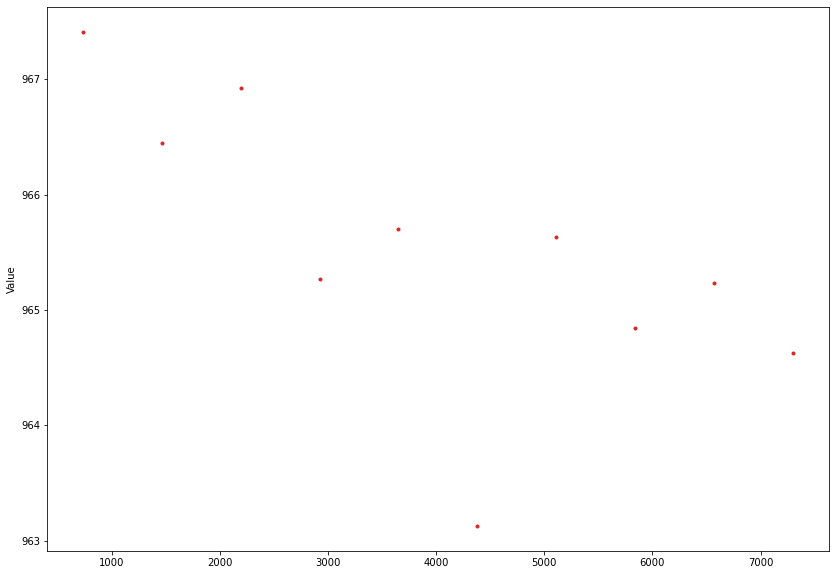

In [9]:
fig, ax1 = plt.subplots(figsize=(14,10))
ax1.set_ylabel('Value')
ax1.plot(df['num_steps'], df['Value'], 'o', markersize=3, color = 'tab:red')
plt.savefig('Images/Proj1_Prod1_F.png')
plt.show()

It looks from this that the value of the product is around USD965, very close the term sheet estimate of USD965.61

Now let's see what happens as we change volatility to see the impact of choosing different rates

In [10]:

def CRRPR1_vols(S0, B, T1, T2, r1, r2, q, vol, volnum, N, Cpn, Face, tco, tcop, tac, tacp):
    """
    Function to calculates the value of a European Put Option using the CRR Binomial Model 
    
    S0: Original Stock Price
    K: Excercise Price of Call Option
    T: Time Length of Option in which to Exercise (In Years)
    r: Annualized Continously Compounded Risk-free Rate
    sigma: Annualized (Future) Volatility of Stock Price Returns
    start_step: Starting time step
    N: Number of time steps
    
    """    
    
    # LIST TO SAVE RESULTS
    crrpr1_AAPL_vols = []
        
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [N+1,N+1] TO STORE ALL STEPS
    # option_value[N+1, N+1]
    option_value = np.zeros([N+1, N+1])

    # CREATE ARRAY FOR STOCK PRICES OF SIZE N+1,N+1
    # stock_value[N+1, N+1]
    stock_value = np.zeros([N+1, N+1])    
    
    # FOR LOOP STATEMENT: For a Binomial Tree from start_step to N
    for k in range(1, volnum+1):
        
        sigma = vol[k]
        
        delta = T1 / N
        u = np.exp(sigma * (delta)**0.5)
        d = 1 / u
        qu = (np.exp((r1-q) * delta) - d) / (u - d)
        qd = 1 - qu
        
        jco1 = [j/delta for j in tco]
        jco = [int(j) for j in jco1]
    
        jac1 = [j/delta for j in tac]
        jac = [int(j) for j in jac1]
        
    # CALCULATE OPTION VALUES AT CERTAIN STEPS AND POSITIONS WITHIN THE BINOMIAL TREE:
    # Start at the last step number because we are going to be moving backwards from step number n to step number 0
    # Hint: j = n and range stop = j 
        j = N
        
        for i in range(0, j+1):    
  
            stock_value[j, i] = S0 * (u**i) * (d**(j - i))
            option_value[j, i] = (Face+Cpn)*np.exp(-r2*(T2-T1))
            if stock_value[j, i] < B:
                option_value[j, i] = (Face*stock_value[j, i]/S0*np.exp(-r2*(T2-T1)))
                         
        for j in range(N-1, -1, -1):
            #if j in jco: print("coupon only",j,jco.index(j))
            #if j in jac: print("autocall",j,jac.index(j))  
            for i in range(0, j+1, 1):
                cont = np.exp(-r2 * delta) * (qu * option_value[j + 1, i + 1] + qd * option_value[j + 1, i])
                stock_value[j, i] = S0 * (u**i) * (d**(j - i))
                if j in jco: 
                    if (stock_value[j, i] >= B): cont = cont + Cpn*np.exp(-r2*(tcop[jco.index(j)]-delta*j))  
                if j in jac: 
                    if stock_value[j, i] >= B:
                        cont += Cpn*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                    if stock_value[j, i] >= S0:
                        cont = (Face + Cpn)*np.exp(-r2*(tacp[jac.index(j)]-delta*j))
                option_value[j, i] = cont    
                    
        output = {'vol': vol[k], 'Value': option_value[0,0]}
        crrpr1_AAPL_vols.append(output)

    return crrpr1_AAPL_vols


In [11]:
ValueV = CRRPR1_vols(S0, B, T1, T2, r1, r2, q, vol, 6, 730*3, Cpn, Face, tco, tcop, tac, tacp)

In [12]:
df = pd.DataFrame.from_dict(ValueV)

In [13]:
df

,vol,Value
0,0.5088,943.103494
1,0.4945,953.464693
2,0.4819,958.296413
3,0.4764,959.811932
4,0.4749,960.225194
5,0.4685,966.920148


In [14]:
df.to_csv("Data/Proj1_Prod1_F_vols.csv", index=False)

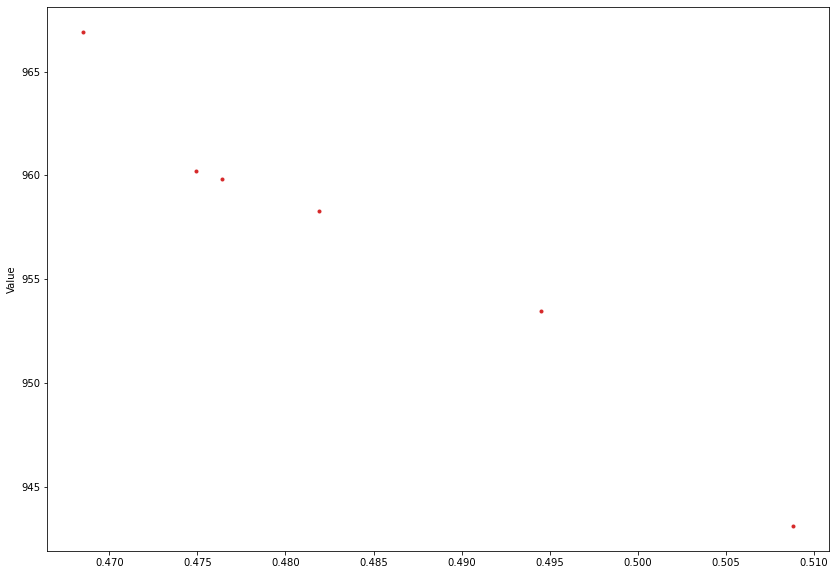

In [15]:
fig, ax1 = plt.subplots(figsize=(14,10))
ax1.set_ylabel('Value')
ax1.plot(df['vol'], df['Value'], 'o', markersize=3, color = 'tab:red')
plt.savefig('Images/Proj1_Prod1_F_vol.png')
plt.show()

We clearly see here that the effect of increasing the volatility is to reduce the value of the product as it makes it more likely that the contingent coupon will not be paid and for the higher volatilities the price falls below the prospectus estimate. The ATM volatility we tried first of all gives the value closest to the prospectus one. 